# Density - ComplexCF
## Orientational Ordering in 2D
The `freud.density` module is intended to compute a variety of quantities that relate spatial distributions of particles with other particles. This example shows how [correlation functions](https://en.wikipedia.org/wiki/Correlation_function_(statistical_mechanics)) can be used to measure orientational order in 2D.

In [1]:
import numpy as np
import freud
import matplotlib.pyplot as plt

This helper function will make plots of the data we generate in this example.

In [2]:
def plot_data(title, points, angles, values, box, ccf, s=200):
    plt.figure(figsize=(16, 6))
    plt.subplot(121)
    for point, angle, value in zip(points, angles, values):
        plt.scatter(point[0], point[1], marker=(4, 0, np.rad2deg(angle)+45),
                    edgecolor='k', c=angle, vmin=-np.pi/4, vmax=np.pi/4, s=s)
    plt.title(title)
    plt.gca().set_xlim([-box.Lx/2, box.Lx/2])
    plt.gca().set_ylim([-box.Ly/2, box.Ly/2])
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.subplot(122)
    plt.title('Orientation Spatial Autocorrelation Function')
    plt.plot(ccf.R, np.real(ccf.RDF))
    plt.xlabel(r'$r$')
    plt.ylabel(r'$C(r)$')
    plt.show()

First, let's generate a 2D structure with perfect orientational order and slight positional disorder (the particles are not perfectly on a grid, but they are perfectly aligned). The color of the particles corresponds to their angle of rotation, so all the particles will be the same color to begin with.

We create a `freud.density.ComplexCF` object to compute the correlation functions. Given a particle orientation $\theta$, we compute its complex orientation value (the quantity we are correlating) as $s = e^{4i\theta}$, to account for the fourfold symmetry of the particles. We will compute the correlation function $C(r) = \left\langle s^*_i(0) \cdot s_j(r) \right\rangle$ by taking the average over all particle pairs $i, j$ and binning the results into a histogram by the distance $r$ between particles $i$ and $j$.

When we compute the correlations between particles, we must use the complex conjugate of the `values` array for one of the arguments. This way, if $\theta_1$ is close to $\theta_2$, then we get $\left(e^{4i\theta_1}\right)^* \cdot \left(e^{4i\theta_2}\right) = e^{4i(\theta_2-\theta_1)} \approx e^0 = 1$.

This system has perfect spatial correlation of the particle orientations, so we see $C(r) = 1$ for all values of $r$.

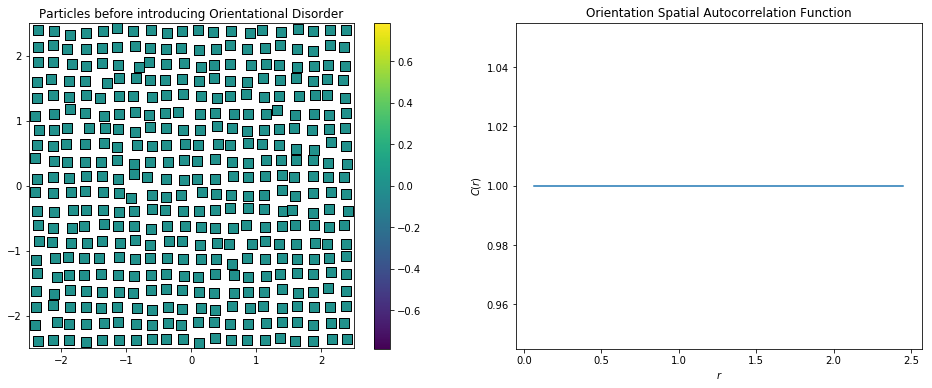

In [3]:
def make_particles(L, repeats):
    # Initialize a box and particle spacing
    box = freud.box.Box.square(L=L)
    dx = box.Lx/repeats

    # Generate points and add random positional noise
    points = np.array([[i, j, 0] for j in np.arange(-(box.Ly+dx)/2, (box.Ly+dx)/2, dx)
                       for i in np.arange(-(box.Lx+dx)/2, (box.Lx+dx)/2, dx)])
    cov = 1e-4*box.Lx*np.eye(3)
    cov[2, 2] = 0
    points += np.random.multivariate_normal(mean=np.zeros(3), cov=cov, size=len(points))
    return box, points

# Make a small system
box, points = make_particles(L=5, repeats=20)

# All the particles begin with their orientation at 0
angles = np.zeros(len(points))
values = np.array(np.exp(angles * 4j))

# Create the ComplexCF compute object and compute the correlation function
ccf = freud.density.ComplexCF(rmax=box.Lx/2, dr=box.Lx/50)
ccf.compute(box, points, np.conj(values), points, values)

plot_data('Particles before introducing Orientational Disorder',
          points, angles, values, box, ccf)

Now we will generate random angles from $-\frac{\pi}{4}$ to $\frac{\pi}{4}$, which orients our squares randomly. The four-fold symmetry of the squares means that the space of unique angles is restricted to a range of $\frac{\pi}{2}$. Again, we compute a complex value for each particle, $s = e^{4i\theta}$.

Because we have purely random orientations, we expect no spatial correlations in the plot above. As we see, $C(r) \approx 0$ for all $r$.

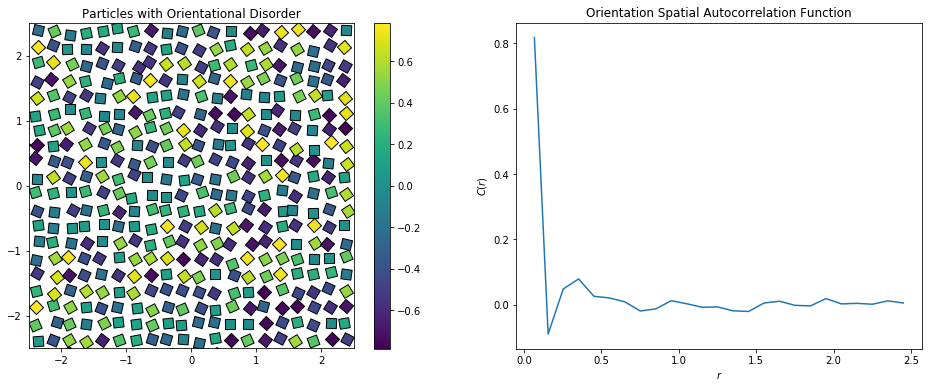

In [4]:
# Change the angles to values randomly drawn from a uniform distribution
angles = np.random.uniform(-np.pi/4, np.pi/4, size=len(points))
values = np.exp(angles * 4j)

# Recompute the correlation functions
ccf.compute(box, points, np.conj(values), points, values)

plot_data('Particles with Orientational Disorder',
          points, angles, values, box, ccf)

The plot below shows what happens when we intentionally introduce a correlation length by adding a spatial pattern to the particle orientations. At short distances, the correlation is very high. As $r$ increases, the oppositely-aligned part of the pattern some distance away causes the correlation to drop.

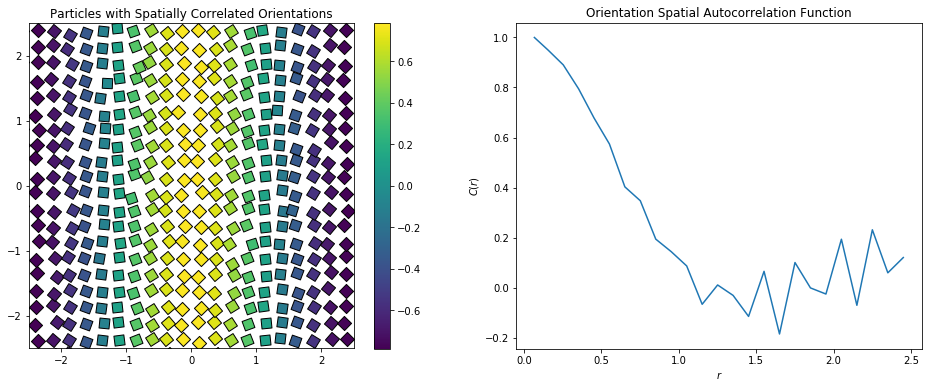

In [5]:
# Use angles that vary spatially in a pattern
angles = np.pi/4 * np.cos(2*np.pi*points[:, 0]/box.Lx)
values = np.exp(angles * 4j)

# Recompute the correlation functions
ccf.compute(box, points, np.conj(values), points, values)

plot_data('Particles with Spatially Correlated Orientations',
          points, angles, values, box, ccf)

In the larger system shown below, we see the spatial autocorrelation rise and fall with damping oscillations.

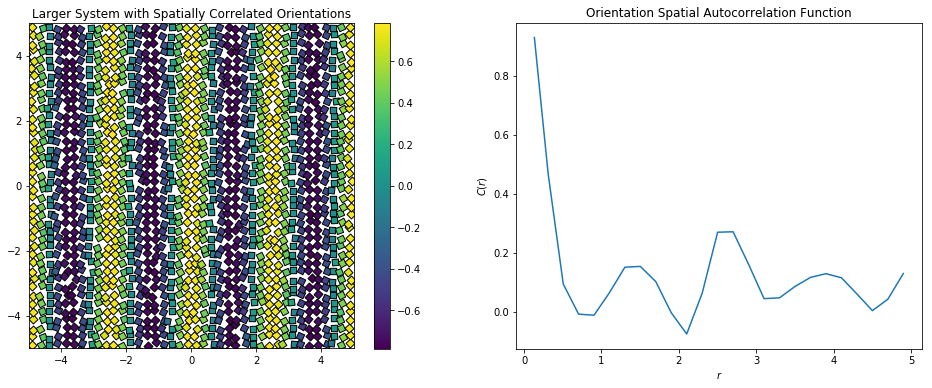

In [6]:
# Make a large system
box, points = make_particles(L=10, repeats=40)

# Use angles that vary spatially in a pattern
angles = np.pi/4 * np.cos(8*np.pi*points[:, 0]/box.Lx)
values = np.exp(angles * 4j)

# Create a ComplexCF compute object
ccf = freud.density.ComplexCF(rmax=box.Lx/2, dr=box.Lx/50)
ccf.compute(box, points, np.conj(values), points, values)

plot_data('Larger System with Spatially Correlated Orientations',
          points, angles, values, box, ccf, s=80)